In [1]:
#this notebook reads the experimental and simulation data from a defined directory
#then a cross-validation protocol on all data is performed using in order to find best regularization type and strength
#ultimately the results published in this study are obtained

In [2]:
import concurrent.futures

In [3]:
def main(regularization_list):
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    import math
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    
    #get experimental data
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #function takes list of file names and concatenated them
    def concatenate_simulation_data(files):
        result=None
        for t in files:
            if result is None:
                result=np.load(t)
                output=+result
            else:
                result=np.load(t)
                output=np.concatenate((output,result))

        return output

    def read_TLs(files):
        corr=[]
        for file in files:
            with open(file, "r") as f:
                for line in f:
                    nums=line.split()
                    if nums:
                        corr.append(np.array([float(i) for i in nums]))
        return np.array(corr)
    
    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            # load "skip" files, with 1 over ten frames only
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))
                    
    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')
    
    #-------------------------------------------------------------------------------
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])

    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    #for the TLs the bias is computed for the respective other forcefield as well both times
    def calculate_TL_bias(Sequence,key):

        directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                     "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                     "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                     ]

        collection_weights=[]
        for index,d in enumerate(directories):
            Metadweight=[]
            with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
                for line in fp:
                    Metadweight.append(float(line))
            collection_weights.append(np.array(Metadweight))

        MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
        MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

        MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
        MetadPot=kBT*np.log(MetadPot)

        if prune==True:
            MetadPot=MetadPot[::skip,:]

        if Sequence=='GAGA':
            if key == 'reference':
                #if nothing is subtracted one obtains the results for the AMBER FF
                bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
            #if one of the two FF is subtracted this improved FF becomes the new reference
            #we choose the second one since this is the proposed one
            if key == 'proposed':
                bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot

        if Sequence=='UUCG':
            if key == 'reference':
                bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
            if key == 'proposed':
                bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot


        del MetadPot1
        del MetadPot2
        del MetadPot

        return bias   

    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight

    #calculate all the weights
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed'),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed'),verbose=False,threshold=1e-20,T=kBT)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)

    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population)
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            #print(func)
            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator,denominator  

        return float(func)
    
    def save(data):
        alpha_list=data[0]
        mini=str(min(alpha_list)).replace('.', '')
        maxi=str(max(alpha_list)).replace('.', '')
        #Training and CV error
        Training_error_list=np.array(data[2][::-1])
        Training_error_std_list=np.array(data[3][::-1])
        CV_error_list=np.array(data[11][::-1])
        CV_error_std_list=np.array(data[12][::-1])
        reference_error=np.array(data[20][::-1])


        with open("./data_produced/CVObservables_bounds_indivComp_errors_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f:
            for index,elem in enumerate(CV_error_list):
                f.write(str(alpha_list[index]) + ' ' + str(Training_error_list[index])+ ' ' + str(Training_error_std_list[index])+ ' ' + str(CV_error_list[index]) + ' ' + str(CV_error_std_list[index])+ ' ' + str(reference_error[index]) + ' ' + '\n')

        #chi2 components Training
        chi2_native_GAGA=np.array(data[4][::-1])
        chi2_native_UUCG=np.array(data[5][::-1])
        chi2_noes=np.array(data[6][::-1])
        chi2_unoes=np.array(data[7][::-1])
        chi2_sugar=np.array(data[8][::-1])
        chi2_backbone1=np.array(data[9][::-1])
        chi2_backbone2=np.array(data[10][::-1])
        with open("./data_produced/CVObservables_bounds_indivComp_chi2Components_Training_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f:    
            for index,elem in enumerate(Training_error_list):
                    f.write(str(alpha_list[index]) + ' ' + str(chi2_native_GAGA[index])+ ' ' + str(chi2_native_UUCG[index])+ ' ' + str(chi2_noes[index]) + ' ' + str(chi2_unoes[index])+ ' ' + str(chi2_sugar[index]) + ' ' + str(chi2_backbone1[index])+ ' ' + str(chi2_backbone2[index]) + '\n')

        #chi2 components CV
        chi2_native_GAGA=np.array(data[13][::-1])
        chi2_native_UUCG=np.array(data[14][::-1])
        chi2_noes=np.array(data[15][::-1])
        chi2_unoes=np.array(data[16][::-1])
        chi2_sugar=np.array(data[17][::-1])
        chi2_backbone1=np.array(data[18][::-1])
        chi2_backbone2=np.array(data[19][::-1])
        with open("./data_produced/CVObservables_bounds_indivComp_chi2Components_CV_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f:
            for index,elem in enumerate(CV_error_list):
                    f.write(str(alpha_list[index]) + ' ' + str(chi2_native_GAGA[index])+ ' ' + str(chi2_native_UUCG[index])+ ' ' + str(chi2_noes[index]) + ' ' + str(chi2_unoes[index])+ ' ' + str(chi2_sugar[index]) + ' ' + str(chi2_backbone1[index])+ ' ' + str(chi2_backbone2[index]) + '\n')


        #lambdas
        lambdas = np.asarray(data[1])
        np.savetxt("./data_produced/CVObservables_bounds_indivComp_Lambdas_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), lambdas, delimiter=',')

        #additional saves of the error components of each leave one out iteration
        collector_Training_chi2_native_GAGA = np.asarray(data[21][::-1])
        np.savetxt("./data_produced/CVObservables_bounds_indivComp_T_GAGA_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), collector_Training_chi2_native_GAGA, delimiter=',')
        collector_Training_chi2_native_UUCG = np.asarray(data[22][::-1])
        np.savetxt("./data_produced/CVObservables_bounds_indivComp_T_UUCG_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), collector_Training_chi2_native_UUCG, delimiter=',')
        collector_CV_chi2_native_GAGA = np.asarray(data[23][::-1])
        np.savetxt("./data_produced/CVObservables_bounds_indivComp_CV_GAGA_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), collector_CV_chi2_native_GAGA, delimiter=',')
        collector_CV_chi2_native_UUCG = np.asarray(data[24][::-1])
        np.savetxt("./data_produced/CVObservables_bounds_indivComp_CV_UUCG_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), collector_CV_chi2_native_UUCG, delimiter=',')

    
    def weighted_avg_and_std(values, weights):
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
        return (average, math.sqrt(variance))
    
    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0]+sugar_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0])

    #regularization_list=['RelativeKishSize']

    for regularization in regularization_list:
        if regularization=='L1' or regularization=='L2':
            alpha_list = np.geomspace(10**-3, 10**4, num=199)
            alpha_list = np.insert(alpha_list, len(alpha_list), 10**7, axis=0)
            alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)
        else:
            alpha_list = np.geomspace(10**-3, 10**7, num=200)
            alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)



    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    alpha=0.0
    regularization='None'
    ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
    print(ref_chi2)

    for regularization in regularization_list:
        print(regularization)
        start_lambdas=[]
        collection=[]


        Training_error_list=[]
        Training_error_std_list=[]
        Training_chi2_native_GAGA_mean=[]
        Training_chi2_native_UUCG_mean=[]
        Training_chi2_noes_mean=[]
        Training_chi2_unoes_mean=[]
        Training_chi2_sugar_mean=[]
        Training_chi2_backbone1_mean=[]
        Training_chi2_backbone2_mean=[]

        CV_error_list=[]
        CV_error_std_list=[]
        CV_chi2_native_GAGA_mean=[]
        CV_chi2_native_UUCG_mean=[]
        CV_chi2_noes_mean=[]
        CV_chi2_unoes_mean=[]
        CV_chi2_sugar_mean=[]
        CV_chi2_backbone1_mean=[]
        CV_chi2_backbone2_mean=[]

        reference_error=[]


        collector_Training_chi2_native_GAGA=[]
        collector_Training_chi2_native_UUCG=[]
        collector_CV_chi2_native_GAGA=[]
        collector_CV_chi2_native_UUCG=[]

        for alpha in reversed(alpha_list):
                print(alpha)
                if not alpha < alpha_list[-1]:
                        for k,elem in enumerate(obs_weight):
                            start_lambdas.append(np.zeros(12))

                Training_error=[]
                Training_chi2_native_GAGA=[]
                Training_chi2_native_UUCG=[]
                Training_chi2_noes=[]
                Training_chi2_unoes=[]
                Training_chi2_sugar=[]
                Training_chi2_backbone1=[]
                Training_chi2_backbone2=[]
                CV_error=[]
                CV_chi2_native_GAGA=[]
                CV_chi2_native_UUCG=[]
                CV_chi2_noes=[]
                CV_chi2_unoes=[]
                CV_chi2_sugar=[]
                CV_chi2_backbone1=[]
                CV_chi2_backbone2=[]
                #normalization
                Training_normalization=[]
                CV_normalization=[]


                for k,elem in enumerate(obs_weight):
                    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
                    obs_weight[k] = 0.0
                    m=minimize(func_and_grad,x0=start_lambdas[k],method='L-BFGS-B', jac=True,bounds=bounds)
                    start_lambdas[k]=m.x


                    collection.append(m.x)

                    t_chi2, t_chi2_backbone1, t_chi2_backbone2, t_chi2_sugar, t_chi2_noes, t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG,denominator=func_and_grad(m.x,gradient=False,regularize=False,components=True)
                    Training_error.append(t_chi2)
                    Training_chi2_native_GAGA.append(t_chi2_native_GAGA)
                    Training_chi2_native_UUCG.append(t_chi2_native_UUCG)
                    Training_chi2_noes.append(t_chi2_noes)
                    Training_chi2_unoes.append(t_chi2_unoes)
                    Training_chi2_sugar.append(t_chi2_sugar)
                    Training_chi2_backbone1.append(t_chi2_backbone1)
                    Training_chi2_backbone2.append(t_chi2_backbone2)
                    Training_normalization.append(denominator)

                    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
                    for i,x in enumerate(obs_weight):
                            if i!=k:
                                obs_weight[i]=0.0

                    cv_chi2,   cv_chi2_backbone1,  cv_chi2_backbone2, cv_chi2_sugar, cv_chi2_noes,  cv_chi2_unoes,cv_chi2_native_GAGA,cv_chi2_native_UUCG,denominator=func_and_grad(m.x,gradient=False,regularize=False,components=True)

                    CV_error.append(cv_chi2)
                    CV_chi2_native_GAGA.append(cv_chi2_native_GAGA)
                    CV_chi2_native_UUCG.append(cv_chi2_native_UUCG)
                    CV_chi2_noes.append(cv_chi2_noes)
                    CV_chi2_unoes.append(cv_chi2_unoes)
                    CV_chi2_sugar.append(cv_chi2_sugar)
                    CV_chi2_backbone1.append(cv_chi2_backbone1)
                    CV_chi2_backbone2.append(cv_chi2_backbone2)
                    CV_normalization.append(denominator)

                mean,std=weighted_avg_and_std(np.array(Training_error).reshape(-1,),np.array(Training_normalization))    
                Training_error_list.append(mean) 
                Training_error_std_list.append(std)

                mean,std=weighted_avg_and_std(np.array(Training_chi2_native_GAGA),np.array(Training_normalization))  
                Training_chi2_native_GAGA_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_native_UUCG),np.array(Training_normalization))  
                Training_chi2_native_UUCG_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_noes),np.array(Training_normalization))  
                Training_chi2_noes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_unoes),np.array(Training_normalization))  
                Training_chi2_unoes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_sugar),np.array(Training_normalization))  
                Training_chi2_sugar_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_backbone1),np.array(Training_normalization))  
                Training_chi2_backbone1_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_backbone2),np.array(Training_normalization))  
                Training_chi2_backbone2_mean.append(mean)

                mean,std=weighted_avg_and_std(np.array(CV_error).reshape(-1,),np.array(CV_normalization))    
                CV_error_list.append(mean) 
                print(mean)
                CV_error_std_list.append(std)

                mean,std=weighted_avg_and_std(np.array(CV_chi2_native_GAGA),np.array(CV_normalization))
                CV_chi2_native_GAGA_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_native_UUCG),np.array(CV_normalization))
                CV_chi2_native_UUCG_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_noes),np.array(CV_normalization))
                CV_chi2_noes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_unoes),np.array(CV_normalization))
                CV_chi2_unoes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_sugar),np.array(CV_normalization))
                CV_chi2_sugar_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_backbone1),np.array(CV_normalization))
                CV_chi2_backbone1_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_backbone2),np.array(CV_normalization))
                CV_chi2_backbone2_mean.append(mean)

                reference_error.append(ref_chi2)

                #additional saves of the error components of each leave one out iteration
                collector_Training_chi2_native_GAGA.append(Training_chi2_native_GAGA)
                collector_Training_chi2_native_UUCG.append(Training_chi2_native_UUCG)
                collector_CV_chi2_native_GAGA.append(CV_chi2_native_GAGA)
                collector_CV_chi2_native_UUCG.append(CV_chi2_native_UUCG)

        list_of_saves=np.array([alpha_list,
        collection,
        Training_error_list,
        Training_error_std_list,
        Training_chi2_native_GAGA_mean,
        Training_chi2_native_UUCG_mean,
        Training_chi2_noes_mean,
        Training_chi2_unoes_mean,
        Training_chi2_sugar_mean,
        Training_chi2_backbone1_mean,
        Training_chi2_backbone2_mean,
        CV_error_list,
        CV_error_std_list,
        CV_chi2_native_GAGA_mean,
        CV_chi2_native_UUCG_mean,
        CV_chi2_noes_mean,
        CV_chi2_unoes_mean,
        CV_chi2_sugar_mean,
        CV_chi2_backbone1_mean,
        CV_chi2_backbone2_mean,
        reference_error,
        collector_Training_chi2_native_GAGA,
        collector_Training_chi2_native_UUCG,
        collector_CV_chi2_native_GAGA,
        collector_CV_chi2_native_UUCG])
        save(list_of_saves)
        print('Cross validation on observables complete, data were saved.')

In [4]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=5)

In [5]:
futureL1 = executor.submit(main,['L1'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
21.803205490112305
L1
10000000.0


In [ ]:
print(futureL1)

In [9]:
futureL2 = executor.submit(main,['L2'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.


In [ ]:
print(futureL2)

In [5]:
futureKishSize = executor.submit(main,['KishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
21.803205490112305
KishSize
10000000.0


In [ ]:
print(futureKishSize)

In [7]:
futureRelativeKishSize = executor.submit(main,['RelativeKishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
21.803205490112305
RelativeKishSize
10000000.0
21.80320366580586
8907354.638610458


In [8]:
print(futureRelativeKishSize)

<Future at 0x7feead5b38e0 state=running>


In [5]:
futureRelativeEntropy = executor.submit(main,['RelativeEntropy'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.


In [6]:
print(futureRelativeEntropy)

<Future at 0x7fe3f4fea910 state=running>


<IPython.core.display.Javascript object>


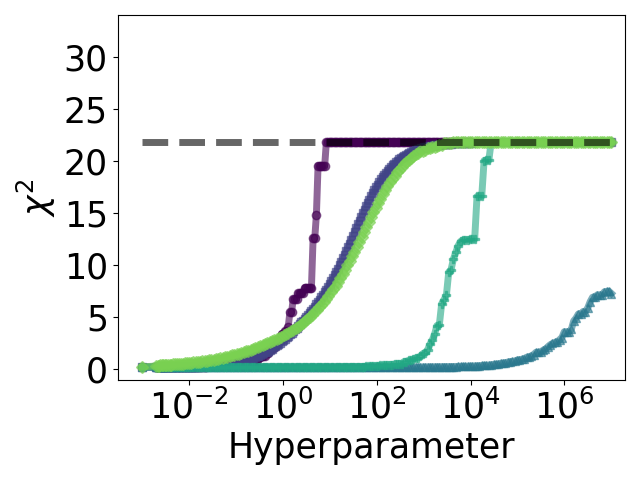

<IPython.core.display.Javascript object>


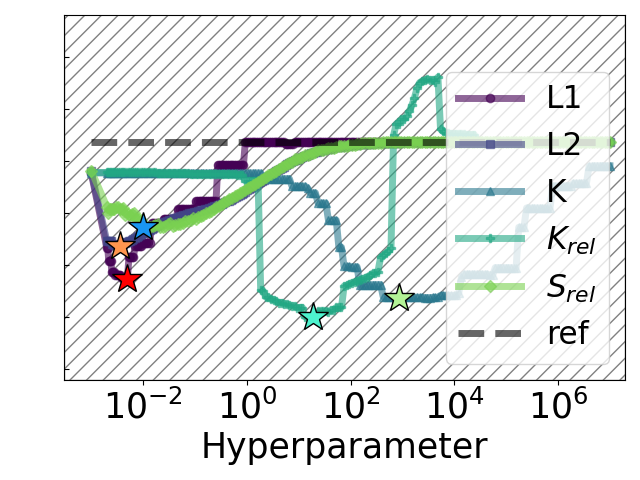

0.003990341831649381
0.0026560877829466868
850.4489341802686
18.679135990207847
0.009011018251665018


In [3]:
import bussilab
from bussilab import wham
import scipy
from scipy.optimize import minimize
import cudamat as cm
import numpy as np
import matplotlib.pyplot as plt
import re
import math
kBT=0.6 #kBT in kcal/mol
np.random.seed(1995)
%matplotlib notebook
eps=1e-30

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    with open('./data_produced/CVObservables_bounds_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:    
            for line in f:
                nums=line.split()
                alpha_list.append(float(nums[0]))
                training_chi2_list.append(float(nums[1])) 
                cv_chi2_list.append(float(nums[3])) 
                ref_chi2_list.append(float(nums[5])) 

    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001
    plt.plot(alpha_list,training_chi2_list,linewidth=5, color=c, marker=m, alpha=0.6, label='%s_%s-regularization' % (regularization,eps))

ax.set_xlim(0.0003,19500000)

plt.plot(alpha_list,ref_chi2_list, '--',linewidth=5,color='black', alpha=0.6, label='reference FF')
plt.ylabel('$ \chi ^2 $',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Hyperparameter',fontsize=25)
plt.ylim(-1,34)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
short_reg=['L1','L2','K','$K_{rel}$','$S_{rel}$']
marker_list=['o','s','^','P','D']
scmap = plt.cm.get_cmap('rainbow_r')
cmap = plt.cm.get_cmap('viridis')

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    sc=scmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    with open('./data_produced/CVObservables_bounds_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:  
               for line in f:
                    nums=line.split()
                    alpha_list.append(float(nums[0]))
                    training_chi2_list.append(float(nums[1])) 
                    cv_chi2_list.append(float(nums[3])) 
                    ref_chi2_list.append(float(nums[5])) 

    print(alpha_list[cv_chi2_list.index(min(cv_chi2_list))])
    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001

    plt.plot(alpha_list,cv_chi2_list, color=c,linewidth=5, marker=m,alpha=0.6, label='%s' % (short_reg[r]))
    plt.plot(alpha_list[cv_chi2_list.index(min(cv_chi2_list))],min(cv_chi2_list), color='black', marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)

rec2 = plt.Rectangle((0.0003,-1),19500000,2000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
ax.add_patch(rec2)   
ax.set_ylim(-1,34)
ax.set_xlim(0.0003,19500000)

plt.plot(alpha_list,ref_chi2_list, '--',linewidth=5,color='black', alpha=0.6, label='ref')
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(color='w',fontsize=25)
plt.tick_params(axis="y",direction="in")
plt.xlabel('Hyperparameter',fontsize=25)
plt.ylim(-1,34)

plt.legend(loc='lower right',fontsize=22.5)
plt.tight_layout()
plt.show()

In [5]:
#the published results are also provided directly, so they can be loaded for visualization instead of rerunning the entire analysis

<IPython.core.display.Javascript object>


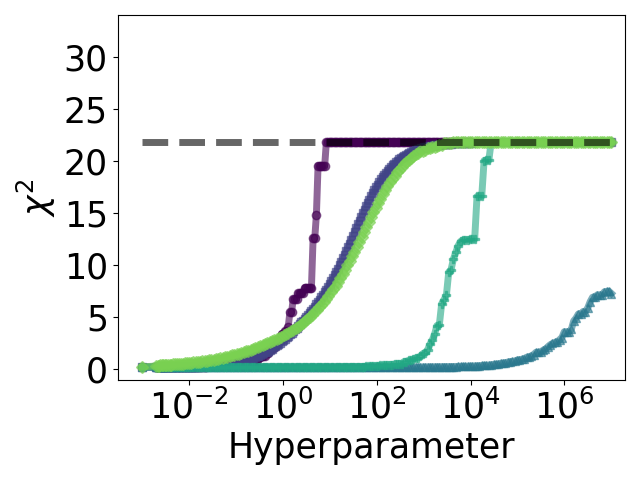

<IPython.core.display.Javascript object>


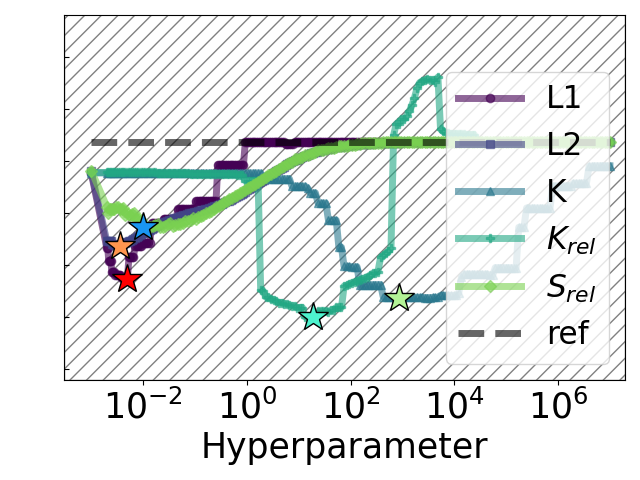

0.003990341831649381
0.0026560877829466868
850.4489341802686
18.679135990207847
0.009011018251665018


In [4]:
eps=1e-30

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    with open('./data_produced/Prepared_CVObservables_bounds_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:    
            for line in f:
                nums=line.split()
                alpha_list.append(float(nums[0]))
                training_chi2_list.append(float(nums[1])) 
                cv_chi2_list.append(float(nums[3])) 
                ref_chi2_list.append(float(nums[5])) 

    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001
    plt.plot(alpha_list,training_chi2_list,linewidth=5, color=c, marker=m, alpha=0.6, label='%s_%s-regularization' % (regularization,eps))

ax.set_xlim(0.0003,19500000)

plt.plot(alpha_list,ref_chi2_list, '--',linewidth=5,color='black', alpha=0.6, label='reference FF')
plt.ylabel('$ \chi ^2 $',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Hyperparameter',fontsize=25)
plt.ylim(-1,34)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
short_reg=['L1','L2','K','$K_{rel}$','$S_{rel}$']
#regularization_list=['L2']
marker_list=['o','s','^','P','D']
scmap = plt.cm.get_cmap('rainbow_r')
cmap = plt.cm.get_cmap('viridis')

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    sc=scmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    with open('./data_produced/Prepared_CVObservables_bounds_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:  
               for line in f:
                    nums=line.split()
                    alpha_list.append(float(nums[0]))
                    training_chi2_list.append(float(nums[1])) 
                    cv_chi2_list.append(float(nums[3])) 
                    ref_chi2_list.append(float(nums[5])) 
    
    print(alpha_list[cv_chi2_list.index(min(cv_chi2_list))])
    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001

    plt.plot(alpha_list,cv_chi2_list,linewidth=5, color=c, marker=m,alpha=0.6, label='%s' % (short_reg[r]))
    plt.plot(alpha_list[cv_chi2_list.index(min(cv_chi2_list))],min(cv_chi2_list), color='black', marker='*', markersize=22, markerfacecolor=sc, markeredgecolor='black', zorder=20)
    
rec2 = plt.Rectangle((0.0003,-1),19500000,2000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
ax.add_patch(rec2)   
ax.set_ylim(-1,34)
ax.set_xlim(0.0003,19500000)

plt.plot(alpha_list,ref_chi2_list, '--',linewidth=5,color='black', alpha=0.6, label='ref')
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(color='w',fontsize=25)
plt.tick_params(axis="y",direction="in")
plt.xlabel('Hyperparameter',fontsize=25)
plt.ylim(-1,34)

plt.legend(loc='lower right',fontsize=22.5)
plt.tight_layout()
plt.show()